In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from lib.clue import Clue, DeductiveSolver
from lib.rl.episode import Episode, EpisodeCompletion
from lib.rl.trainer import Trainer
import re


def sample_random_episode() -> Episode:
    game = Clue(
        num_players=3,
        elements={
            "suspect": Clue.suspects[:3],
            "weapon": Clue.weapons[:3],
            "room": Clue.rooms[:3],
            # "motive": Clue.motives[:6],
            # "time": Clue.get_times("21:00", "03:00", "1h"),
        },
    )
    game.play(
        deductive_solver=DeductiveSolver(
            # note_cards_in_hand=False,
            # note_responses_to_suggestions=False,
            # note_cards_that_players_do_not_have=False,
            # check_unique_card_placement_constraints=False,
            # check_player_hand_size_constraints=False,
            check_solution_has_one_and_only_one_card_per_element=False,
            check_one_of_constraints=False,
            check_inverse_one_of_constraints=False,
            merge_and_check_disjoint_inverse_one_of_constraints=False,
            exhaustively_test_possible_assignments=False,
        ),
        cp_solver_max_solve_time_per_turn=0.01,
        check_cp_solver_grid=False,
        check_if_deductive_solver_and_cp_solver_grids_match=False,
        print_playthrough=False,
    )
    prompt = game.get_prompt()
    follow_up = "Fill out your answer like this:\n" + "\n".join(
        f"{element.capitalize()}: <#{element.upper()}#>" for element in game.elements
    )

    async def reward_completion(completion: EpisodeCompletion) -> EpisodeCompletion:
        follow_up_completion = await completion.follow_up(
            messages=[
                {"role": "user", "content": follow_up},
            ]
        )
        answer = follow_up_completion.last_assistant_message.get("content")
        assert isinstance(answer, str)
        completion.reward = sum(
            [
                bool(
                    re.search(
                        f"{element}: {solution}",
                        answer,
                        re.IGNORECASE,
                    )
                )
                for element, solution in game.solution.items()
            ]
        ) / len(game.solution)
        return completion

    async def on_sample(completions: list[EpisodeCompletion]) -> None:
        for completion in await asyncio.gather(
            *[reward_completion(completion) for completion in completions]
        ):
            completion.commit()

    return Episode(
        messages=[{"role": "user", "content": prompt}],
        on_sample=on_sample,
    )


def train_episodes():
    while True:
        yield sample_random_episode()


trainer = Trainer(
    base_model="NousResearch/Hermes-2-Theta-Llama-3-8B",
    samples_per_episode=8,
    branch_factor=2,
    train_episodes=train_episodes(),
    episodes_per_iteration=128,
    val_episodes=(sample_random_episode() for _ in range(64)),
    tune_sequence_length=16384,
    vllm_kwargs=dict(disable_log_requests=True),
    vllm_max_concurrent_requests=256,
)

/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION


INFO 11-20 22:01:11 llm_engine.py:237] Initializing an LLM engine (vdev) with config: model='NousResearch/Hermes-2-Theta-Llama-3-8B', speculative_config=None, tokenizer='NousResearch/Hermes-2-Theta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=NousResearch/Hermes-2-Theta-Llama-3-8B, use_v2_block_manager=True, num_scheduler_steps=1, chunked_

In [4]:
await trainer.eval("val")

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --disable-log-requests --api-key=default


/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION


INFO 11-20 22:01:19 api_server.py:528] vLLM API server version dev
INFO 11-20 22:01:19 api_server.py:529] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_path=None, middleware=[], return_tokens_as_token_ids=False, disable_frontend_multiprocessing=False, enable_auto_tool_choice=False, tool_call_parser=None, tool_parser_plugin='', model='NousResearch/Hermes-2-Theta-Llama-3-8B', tokenizer=None, skip_tokenizer_init=False, revision=None, code_revision=None, tokenizer_revision=None, tokenizer_mode='auto', trust_remote_code=False, download_dir=None, load_format='auto', config_format='auto', dtype='auto', kv_cache_dtype='au

/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION


INFO 11-20 22:01:29 llm_engine.py:237] Initializing an LLM engine (vdev) with config: model='NousResearch/Hermes-2-Theta-Llama-3-8B', speculative_config=None, tokenizer='NousResearch/Hermes-2-Theta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=NousResearch/Hermes-2-Theta-Llama-3-8B, use_v2_block_manager=True, num_scheduler_steps=1, chunked_

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  1.54it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.29it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.68it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.52it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.51it/s]



INFO 11-20 22:01:34 model_runner.py:1071] Loading model weights took 14.9595 GB
INFO 11-20 22:01:35 gpu_executor.py:122] # GPU blocks: 9604, # CPU blocks: 2048
INFO 11-20 22:01:35 gpu_executor.py:126] Maximum concurrency for 8192 tokens per request: 18.76x
INFO 11-20 22:01:38 model_runner.py:1402] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-20 22:01:38 model_runner.py:1406] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-20 22:01:50 model_runner.py:1530] Graph capturing finished in 12 secs.
INFO 11-20 22:01:50 api_server.py:232] vLLM to use /tmp/tmpdm0swwnl as PROMETHEUS_MULTIPROC_DIR
WARNING 11-20 22:01:50 serving_embedding.py:199] 

INFO:     Started server process [14296]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on socket ('0.0.0.0', 8000) (Press CTRL+C to quit)


INFO:     127.0.0.1:42386 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully


val:   0%|          | 0/1 [00:00<?, ?episode/s]

APIConnectionError: Connection error.

In [4]:
await trainer.explore()

explore:   0%|          | 0/128 [00:00<?, ?episode/s]

BadRequestError: Error code: 400 - {'object': 'error', 'message': "This model's maximum context length is 8192 tokens. However, you requested 8234 tokens in the messages, Please reduce the length of the messages.", 'type': 'BadRequestError', 'param': None, 'code': 400}

In [6]:
episodes: list[Episode] = trainer.eval_episodes["val"]  # type: ignore
divisor = max(
    sum(
        1
        for episode in episodes
        if any(child.model == trainer.model for child in episode.completion.children)
    ),
    1,
)
score = sum(
    episode.completion.value(model=trainer.model) for episode in episodes
) / divisor
score, divisor

(0.49479166666666663, 64)

In [10]:
[len(list(episode.completion.descendants())) for episode in episodes]

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [24]:
list(list(episodes[0].completion.children)[0].children)[0].message_params()

[{'role': 'assistant', 'content': '\n<|im_end|>'}]

In [9]:
[episode.completion.value(model=trainer.model) for episode in episodes]

[1.3333333333333333,
 0.0,
 0.3333333333333333,
 1.3333333333333333,
 2.0,
 1.0,
 0.0,
 2.0,
 0.0,
 0.0,
 1.0,
 2.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.0,
 1.3333333333333333,
 0.6666666666666666,
 1.3333333333333333,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 1.3333333333333333,
 0.6666666666666666,
 1.3333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.0,
 0.6666666666666666,
 1.3333333333333333,
 0.0,
 1.6666666666666665,
 0.0,
 0.6666666666666666,
 1.3333333333333333,
 0.0,
 0.6666666666666666,
 1.3333333333333333,
 1.3333333333333333,
 0.0,
 1.3333333333333333,
 0.0,
 1.3333333333333333,
 0.0,
 1.3333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.0,
 0.6666666666666666,
 1.3333333333333333,
 0.6666666666666666,
 0.0,
 0.6666666666666666,
 0.0,
 0.3333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 1.3333333333

In [8]:
sum(
    sum(child.model == trainer.model for child in episode.completion.children)
    for episode in episodes
)

64

[Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(samples=1, weight=1.0),
 Episode(s

In [5]:
trainer.eval_scores["val"]

{'NousResearch/Hermes-2-Theta-Llama-3-8B': 0.8854166666666666}

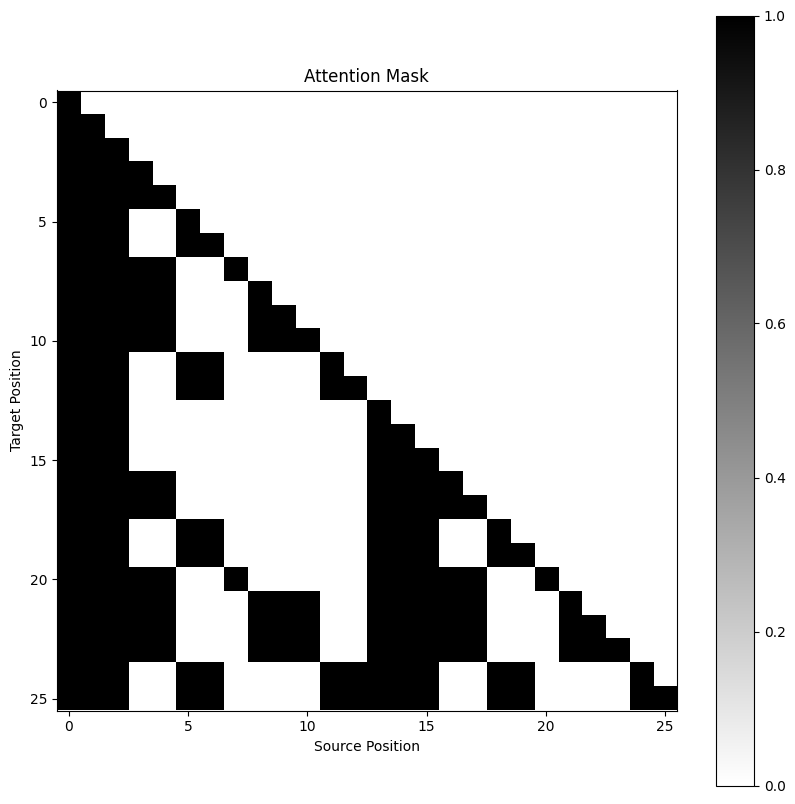

In [96]:
import torch


def get_mask(ids: torch.Tensor, parent_ids: torch.Tensor) -> torch.Tensor:
    """
    Creates a causal attention mask based on token group IDs and their parent relationships.

    Each token can attend to:
    1. All preceding tokens in its own group (tokens with same ID)
    2. All tokens in any ancestor group (following parent_ids chain up)
    The mask enforces causality - tokens cannot attend to future positions.

    Args:
        ids: 1D tensor of token group IDs. Shape: [sequence_length]
        parent_ids: 1D tensor of parent group IDs. Shape: [sequence_length]
            Any integer value is valid - if a parent ID is not found in ids,
            that group is treated as a root node.
            Each ID must have a corresponding parent ID at the same index.

    Returns:
        2D boolean tensor of shape [sequence_length, sequence_length] where
        mask[i,j] = True means position i can attend to position j.
        False means position i cannot attend to position j.

    Example:
        ids = torch.tensor([0, 0, 1, 1])
        parent_ids = torch.tensor([100, 100, 0, 0])
        # Group 1 tokens can attend to group 0 tokens since 0 is their parent
        # Group 0's parent (100) is not in ids so it's treated as root
    """
    # Create mask of shape [seq_len, seq_len] initialized to False
    seq_len = len(ids)
    mask = torch.zeros((seq_len, seq_len), dtype=torch.bool)

    # For each target position
    for i in range(seq_len):
        # Get current id and parent id
        curr_id = ids[i]
        curr_parent = parent_ids[i]

        # For each source position up to and including target
        for j in range(i + 1):
            # Token can attend to itself and earlier tokens in same group
            if ids[j] == curr_id:
                mask[i, j] = True

            # Token can attend to tokens in ancestor groups
            ancestor_id = curr_parent
            while ancestor_id in ids:  # Only follow chain while ancestor exists in ids
                if ids[j] == ancestor_id:
                    mask[i, j] = True
                # Move up to next ancestor
                # Find first occurrence of current ancestor to get its parent
                ancestor_idx = torch.where(ids == ancestor_id)[0][0]
                ancestor_id = parent_ids[ancestor_idx]

    return mask


def get_fast_mask(ids: torch.Tensor, parent_ids: torch.Tensor) -> torch.Tensor:
    """Faster implementation of get_mask using vectorized operations"""
    seq_len = len(ids)

    # Get unique group IDs and map them to indices
    unique_ids = torch.unique(ids)
    group_id_list = unique_ids.tolist()  # Converts tensor to list of Python numbers
    group_id_to_index = {group_id: idx for idx, group_id in enumerate(group_id_list)}
    num_groups = len(unique_ids)

    # Build group_id_to_parent_id mapping
    group_parents = {}
    for group_id in group_id_list:
        indices = (ids == group_id).nonzero(as_tuple=True)[0]
        idx = indices[0].item()  # Select the first occurrence
        parent_id = parent_ids[idx].item()
        group_parents[group_id] = parent_id

    # For each group, compute its ancestors
    group_ancestors = {}
    for group_id in group_id_list:
        ancestors = set()
        parent_id = group_parents.get(group_id, None)
        while parent_id in group_id_list and parent_id not in ancestors:
            ancestors.add(parent_id)
            parent_id = group_parents.get(parent_id, None)
        group_ancestors[group_id] = ancestors

    # Create allowed_groups per group index
    allowed_groups = torch.zeros((num_groups, num_groups), dtype=torch.bool)
    for i, group_id in enumerate(group_id_list):
        # Each group can attend to itself
        allowed_groups[i, i] = True
        # And its ancestors
        for ancestor_id in group_ancestors[group_id]:
            ancestor_idx = group_id_to_index[ancestor_id]
            allowed_groups[i, ancestor_idx] = True

    # Map positions to group indices
    group_indices = torch.tensor(
        [group_id_to_index[group_id.item()] for group_id in ids], dtype=torch.long
    )

    # Get allowed groups per position
    allowed_groups_per_position = allowed_groups[
        group_indices
    ]  # Shape: [seq_len, num_groups]

    # Create group indices matrix for source positions
    group_indices_source = group_indices.unsqueeze(0).expand(
        seq_len, seq_len
    )  # Shape: [seq_len, seq_len]

    # Compute mask by checking if source group is allowed for target position
    mask = allowed_groups_per_position.gather(1, group_indices_source)

    # Enforce causality (tokens cannot attend to future positions)
    causal_mask = torch.tril(torch.ones(seq_len, seq_len, dtype=torch.bool))
    mask = mask & causal_mask

    return mask


ids = torch.tensor([0, 0, 0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5] * 2)
parent_ids = torch.tensor([-1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2] * 2)
mask = get_mask(ids, parent_ids)
fast_mask = get_fast_mask(ids, parent_ids)
assert torch.all(mask == fast_mask), "Fast implementation does not match original"

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(fast_mask, cmap="binary")
plt.colorbar()
plt.title("Attention Mask")
plt.xlabel("Source Position")
plt.ylabel("Target Position")
plt.show()

In [187]:
def get_faster_mask(ids: torch.Tensor, parent_ids: torch.Tensor) -> torch.Tensor:
    mask = ids.unsqueeze(0) == ids.unsqueeze(1)
    _mask = mask | (ids.unsqueeze(0) == parent_ids.unsqueeze(1))
    parent_ids = parent_ids[ids]
    while torch.any(mask != _mask):
        mask = _mask
        _mask = mask | (ids.unsqueeze(0) == parent_ids.unsqueeze(1))
        parent_ids = parent_ids[parent_ids]
    mask &= torch.tril(torch.ones_like(mask))
    return mask

In [100]:
%%timeit
get_faster_mask(ids, parent_ids)

52.4 μs ± 2.08 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [376]:
import random


class Node:
    def __init__(self, id: int, parent: "Node | None" = None, size: int = 1):
        self.id = id
        self.parent = parent
        self.size = size


nodes = [Node(id=0, size=random.randint(1, 1)), Node(id=1, size=random.randint(1, 1))]
for i in range(2, 8):
    parent = random.choice(nodes)
    size = random.randint(1, 2)
    node = Node(id=i, parent=parent, size=size)
    nodes.append(node)
ids = torch.tensor([node.id for node in nodes for _ in range(node.size)])
parent_ids = torch.tensor(
    [
        node.parent.id if node.parent else node.id
        for node in nodes
        for _ in range(node.size)
    ]
)
# mask = get_mask(ids, parent_ids)
# faster_mask = get_faster_mask(ids, parent_ids)
torch.stack([ids, parent_ids])

tensor([[0, 1, 2, 3, 4, 5, 5, 6, 7],
        [0, 1, 0, 0, 1, 2, 2, 3, 5]])

In [406]:
def mask_and_pos_ids(
    ids: torch.Tensor, parent_ids: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    """Creates an attention mask and position IDs for hierarchical attention based on node IDs and their parent IDs.

    Args:
        ids: A tensor of shape (batch_size, sequence_length) containing node IDs
        parent_ids: A tensor of shape (batch_size, sequence_length) containing parent IDs for each node

    Returns:
        A tuple containing:
        - mask: A boolean tensor of shape (batch_size, sequence_length, sequence_length) where True indicates
          allowed attention connections. Each position can attend to itself and any of its ancestors
          in the hierarchy, but only for previous positions (due to causal masking).
        - pos_ids: A tensor of shape (batch_size, sequence_length, sequence_length) containing relative
          position IDs for each allowed attention connection, with -1 for masked positions.
    """
    mask = ids.unsqueeze(1) == ids.unsqueeze(2)
    _mask = mask | (ids.unsqueeze(1) == parent_ids.unsqueeze(2))
    while torch.any(mask != _mask):
        parent_ids = parent_ids.gather(
            1, torch.argmax((parent_ids.unsqueeze(2) == ids.unsqueeze(1)).int(), dim=2)
        )
        mask = _mask
        _mask = mask | (ids.unsqueeze(1) == parent_ids.unsqueeze(2))
    mask &= torch.tril(torch.ones_like(mask, dtype=torch.bool, device=ids.device))
    # mask = torch.linalg.matrix_power(mask.float(), mask.size(1) - 1) > 0
    pos_ids = (torch.where(mask, mask.cumsum(2), 0) - 1).max(1).values
    return mask, pos_ids


def test_mask_and_pos_ids(
    ids: list[int],
    parent_ids: list[int],
    expected_mask: list[list[int]],
    expected_pos_ids: list[int],
):
    mask, pos_ids = mask_and_pos_ids(
        ids=torch.tensor([ids]), parent_ids=torch.tensor([parent_ids])
    )
    assert torch.all(mask.int() == torch.tensor([expected_mask])), f"\n{mask.int()[0]}"
    assert torch.all(
        pos_ids == torch.tensor([expected_pos_ids])
    ), f"{pos_ids[0].tolist()}"


test_mask_and_pos_ids(
    ids=[0, 1],
    parent_ids=[0, 1],
    expected_mask=[[1, 0], [0, 1]],
    expected_pos_ids=[0, 0],
)

test_mask_and_pos_ids(
    ids=[0, 1, 1],
    parent_ids=[0, 0, 0],
    expected_mask=[[1, 0, 0], [1, 1, 0], [1, 1, 1]],
    expected_pos_ids=[0, 1, 2],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3],
    parent_ids=[0, 0, 1, 2],
    expected_mask=[[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]],
    expected_pos_ids=[0, 1, 2, 3],
)

test_mask_and_pos_ids(
    ids=[0, 0, 1, 1],
    parent_ids=[0, 0, 1, 1],
    expected_mask=[[1, 0, 0, 0], [1, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 1]],
    expected_pos_ids=[0, 1, 0, 1],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3],
    parent_ids=[0, 1, 0, 1],
    expected_mask=[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1]],
    expected_pos_ids=[0, 0, 1, 1],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 2, 3, 3],
    parent_ids=[0, 1, 0, 0, 1, 1],
    expected_mask=[
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 1],
    ],
    expected_pos_ids=[0, 0, 1, 2, 1, 2],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3, 4, 4, 5, 5],
    parent_ids=[0, 0, 1, 1, 2, 2, 3, 3],
    expected_mask=[
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 1, 1],
    ],
    expected_pos_ids=[0, 1, 2, 2, 3, 4, 3, 4],
)

test_mask_and_pos_ids(
    ids=[2, 1, 0],
    parent_ids=[2, 2, 0],
    expected_mask=[
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1],
    ],
    expected_pos_ids=[0, 1, 0],
)

RuntimeError: self must be a matrix

In [397]:
import torch

def compute_reachability_matrix(adj_matrix):
    # Number of nodes
    num_nodes = adj_matrix.size(0)

    # Start with the adjacency matrix as reachability
    reachability = adj_matrix.clone()

    # Add paths of length 2 to N-1
    for _ in range(num_nodes - 1):
        # Update reachability with additional paths
        reachability = reachability + torch.mm(reachability, adj_matrix)

    # Convert to binary (reachable or not)
    reachability = (reachability > 0).float()

    return reachability

# Example adjacency matrix
adj_matrix = torch.tensor([
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

reachability_matrix = compute_reachability_matrix(adj_matrix)
print(reachability_matrix)

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [0., 0., 0., 1.]])


In [399]:
def compute_reachability_matrix_one_swoop(adj_matrix):
    num_nodes = adj_matrix.size(0)

    # Compute the series sum: (I + A + A^2 + ... + A^(N-1))
    reachability = torch.matrix_power(adj_matrix, num_nodes - 1)

    # Binarize the result
    reachability = (reachability > 0).float()

    return reachability

reachability_matrix = compute_reachability_matrix_one_swoop(adj_matrix)
print(reachability_matrix)

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [0., 0., 0., 1.]])


In [403]:
import random


class Node:
    def __init__(self, id: int, parent: "Node | None" = None, size: int = 1):
        self.id = id
        self.parent = parent
        self.size = size


nodes = [Node(id=0, size=random.randint(1, 1)), Node(id=1, size=random.randint(1, 1))]
for i in range(2, 128):
    parent = random.choice(nodes)
    size = random.randint(1, 128)
    node = Node(id=i, parent=parent, size=size)
    nodes.append(node)
ids = torch.tensor([node.id for node in nodes for _ in range(node.size)])
parent_ids = torch.tensor(
    [
        node.parent.id if node.parent else node.id
        for node in nodes
        for _ in range(node.size)
    ]
)
# mask = get_mask(ids, parent_ids)
# faster_mask = get_faster_mask(ids, parent_ids)
torch.stack([ids, parent_ids])

tensor([[  0,   1,   2,  ..., 127, 127, 127],
        [  0,   1,   1,  ...,  43,  43,  43]])

In [391]:
len(ids)

8292

In [404]:
%%timeit
_ = mask_and_pos_ids(torch.stack([ids, ids]), torch.stack([parent_ids, parent_ids]))

27.9 s ± 85.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [148]:
def show(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap="binary")
    plt.colorbar()
    plt.title("Attention Mask")
    plt.xlabel("Source Position")
    plt.ylabel("Target Position")
    plt.show()

In [2]:
import asyncio

process = await asyncio.create_subprocess_exec(
    "vllm",
    "serve",
    "NousResearch/Hermes-2-Theta-Llama-3-8B",
    stdout=asyncio.subprocess.PIPE,
    stderr=asyncio.subprocess.PIPE,
)
while True:
    print((await process.stdout.readline()).decode())

INFO 11-18 18:14:23 api_server.py:528] vLLM API server version dev

INFO 11-18 18:14:23 api_server.py:529] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key=None, lora_modules=None, prompt_adapters=None, chat_template=None, response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_path=None, middleware=[], return_tokens_as_token_ids=False, disable_frontend_multiprocessing=False, enable_auto_tool_choice=False, tool_call_parser=None, tool_parser_plugin='', model='NousResearch/Hermes-2-Theta-Llama-3-8B', tokenizer=None, skip_tokenizer_init=False, revision=None, code_revision=None, tokenizer_revision=None, tokenizer_mode='auto', trust_remote_code=False, download_dir=None, load_format='auto', config_format='auto', dtype='auto', kv_cache_dtype='auto',

In [ ]:
from lib.vllm import start_vllm_server, vllm_server_metrics
import os

model = "NousResearch/Hermes-2-Theta-Llama-3-8B"

os.environ["VLLM_ALLOW_LONG_MAX_MODEL_LEN"] = "1"
shutdown_server, client = await start_vllm_server(
    disable_log_requests=True,
    max_model_len=16384,
    model=model,
)

In [ ]:
import asyncio
from lib.rl.episode import Episode
from typing import AsyncIterable, Literal

Split = Literal["train", "val", "test"]


async def episodes(split: Split) -> AsyncIterable[Episode]:
    for _ in range(10):
        await asyncio.sleep(1)
        yield Episode()  # type: ignore


async for episode in episodes(split="val"):
    print(episode)

In [ ]:
from lib.rl.trainer import Trainer

episode = Episode()

Trainer(
    base_model=model,
    episodes={
        "train": [episode],
        "val": [episode],
        "test": [episode],
    },
)